In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pprint import pprint
from itertools import combinations, cycle, islice
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, FeatureAgglomeration
from sklearn.feature_extraction import DictVectorizer
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

In [2]:
from metagov import at2df # Small custom wrapper functions for the Airtable library

In [3]:
# Plot formatting
DEFAULT_COLOR = '#66C2A5'
sns.set(rc={"figure.figsize":(7, 5)})
sns.set(font_scale=1.25)

In [4]:
# Output settings
SAVE = True
SAVEDIR = 'tmp'
kwargs_svg = {'format': 'svg', 'bbox_inches': 'tight'}
kwargs_png = {'format': 'png', 'bbox_inches': 'tight', 'dpi': 300}

# Cryptopolitical Typology Quiz preliminary analysis

The [Cryptopolitical Typology Quiz](https://metagov.typeform.com/cryptopolitics) was developed by the [Metagovernance Project](https://metagov.org/) to help the crypto community understand its political, economic, and governance beliefs. Live survey results are available in a [Typeform report](https://metagov.typeform.com/report/bz9SbjUU/ZY07qRfTs68oypzt).

This notebook contains a preliminary analysis of data available as of January 9, 2022 on the [Govbase Airtable database](https://airtable.com/shr9LYMni8pBUVD6q/tblvwbt4KFm8MOSUQ). This includes:
- Importing the data
- Response rates
- Distribution of (and correlation between) faction assignments
- Distribution of (and correlation between) responses to individual questions
- Bitcoin versus Ethereum
- Feature selection, dimensionality reduction, and clustering

To run this analysis notebook yourself, you will need an Airtable API key. If you are interested in supporting the Cryptopolitics project, please get in touch with [josh@metagov.org](josh@metagov.org), drop a coin in our [Gitcoin grant](https://gitcoin.co/grants/1573/govbase-a-database-for-daos-and-other-online-comm), or join us in the [Metagov Discord](https://discord.gg/7k26vVvY9e).

## Importing the data
Use an API key and a small wrapper around the [Airtable API library](https://pypi.org/project/airtable/) to import the relevant columns.

In [5]:
at = at2df.get_airtable()

In [6]:
df = at2df.get_table_as_df(at, 'Cryptopolitical Typology Quiz')

In [7]:
# Define relevant columns lists, in order
cols_questions_orig = ['1. Which statement comes closest to your views?', 
                       '2. Which blockchain is the best?','3', '4', '5', '6', '7', '8',
                       '9. In order to grow, the crypto ecosystem should:','10', '11', '12', '13',
                       '14. To get more favorable regulation of cryptocurrencies from national governments, the most important thing the crypto community can do is:',
                       '15', '16. Who should have decision-making power over a blockchain?', '17. I\'m here for...',
                       '18. Do you consider yourself:', '19. OPTIONAL: Do you affiliate with any of the following ecosystems or communities?']
cols_results = ['classification', 'politics', 'economics', 'governance']

def rename_col(x):
    """Rename question columns (from cols_questions_orig) to Q{num}; leave the rest as is"""
    if x[0].isdigit():
        return 'Q'+x.split('.')[0]
    else:
        return x

# Rename question columns for easier accessing/visualization throughout
cols_questions = [rename_col(x) for x in cols_questions_orig]
df.rename(columns=rename_col, inplace=True)

# To convert back and forth between column names and question number
n2qDict = {i+1: x for (i, x) in enumerate(cols_questions)}
q2nDict = {x: i+1 for (i, x) in enumerate(cols_questions)}

In [8]:
# Define the canonical order for the factions/classes (for display purposes)
factionOrders = {'politics': ['Crypto-leftist', 'DAOist', 'True neutral', 'Crypto-libertarian', 'Crypto-ancap'],
                 'economics': ['Earner', 'Cryptopunk', 'NPC', 'Techtrepreneur', 'Degen'],
                 'governance': ['Walchian', 'Zamfirist', 'Noob', 'Gavinist', 'Szabian']}

In [9]:
# Split data into question responses and faction results DataFrames
df_questions = df[cols_questions]
df_results = df[cols_results]

## Response rates
How many respondents were there, and how thoroughly did they fill out the survey?

In [10]:
# Q2 and Q19 ask about affiliations with specific blockchains, ecosystems, or
# other crypto communities.

df_tmp = df_questions.copy().drop(columns=['Q2', 'Q19'])
gb_tmp = df_tmp.groupby(list(df_tmp.columns), dropna=False)
nResponses = len(df_tmp.index)
print(f"Number of responses: {nResponses}")
print(f"Number of unique responses (ignoring Q2 and Q19): {gb_tmp.ngroups}\n")

df_tmp = df_tmp.dropna()
gb_tmp = df_tmp.groupby(list(df_tmp.columns), dropna=False)
print(f"Number of responses with no unanswered questions: {len(df_tmp.index)}")
print(f"Number of unique responses with no unanswered questions (ignoring Q2 and Q19): {gb_tmp.ngroups}")

Number of responses: 519
Number of unique responses (ignoring Q2 and Q19): 513

Number of responses with no unanswered questions: 470
Number of unique responses with no unanswered questions (ignoring Q2 and Q19): 464


In [11]:
# This could help us know which questions or set of possible choices were
# insufficient to capture the range of beliefs held.
# Note that Q2 could only be answered if a particular response was given for Q1.

print("Percentage of respondents who chose not to answer each question:")
for col in cols_questions[:-1]:
    print(f"{col}:\t{100*df_questions[col].isnull().sum()/nResponses:.1f}%")

Percentage of respondents who chose not to answer each question:
Q1:	0.6%
Q2:	76.3%
Q3:	0.8%
Q4:	0.6%
Q5:	0.6%
Q6:	0.6%
Q7:	1.0%
Q8:	1.0%
Q9:	0.8%
Q10:	1.3%
Q11:	1.9%
Q12:	1.7%
Q13:	0.8%
Q14:	1.2%
Q15:	1.3%
Q16:	1.5%
Q17:	1.3%
Q18:	0.6%


## Distribution of faction assignments
- What percentage of respondents were assigned each faction/class?
- Are faction/class assignments correlated? This is an indication of how independent our defined "axes" of politics, economics, and governance are.

In [12]:
def plot_pie_faction(col, df, colors=sns.color_palette("Set2")):
    """Plot pie chart for overall faction"""
    
    vals = df_results[col].value_counts()
    n = vals.sum()
    labels = [f"{k} ({100*v/n:.0f}%)" for k, v in vals.items()]
    
    plt.figure()
    fig = plt.pie(vals, labels=labels, colors=colors, wedgeprops=dict(width=0.5))
    
    if SAVE:
        fname = f'{SAVEDIR}/cryptopolitics_faction_{col}'
        plt.savefig(f'{fname}.svg', **kwargs_svg)
        plt.savefig(f'{fname}.png', **kwargs_png)

In [13]:
def cramers_v(q1, q2, verbose=False):
    """Calculate Cramer's V for two categorical questions by cross-tabulating"""
    
    assert len(q1.index) == len(q2.index), "Make sure the datasets are of equal length"
    
    # Skip questions with list as response
    try:
        ct = pd.crosstab(q1, q2)
    except TypeError:
        return np.nan
    
    chi2 = stats.chi2_contingency(ct)[0]
    n = len(q1.index)
    nRows, nCols = ct.shape
    minDim = min(nRows-1, nCols-1)
    
    # Only compute if both questions have at least two observed responses
    # E.g., Q2 is only answered if a particular answer is given to Q1
    if minDim == 0:
        return np.nan
    
    V = np.sqrt((chi2/n)/minDim)

    if verbose:   
        ct_norm = pd.crosstab(q1, q2, normalize=True)*100
        rowName = q1.name
        colName = q2.name
        rowList = factionOrders[rowName]
        colList = factionOrders[colName]
        ct_norm = ct_norm.reindex(rowList)[colList]
     
        sns.heatmap(ct_norm, annot=True, fmt="0.1f", cmap="YlGnBu", cbar_kws={'label': "Percentage of respondents"})
        
        if SAVE:
            fname = f"{SAVEDIR}/cryptopolitics_{rowName}-{colName}_heatmap"
            plt.savefig(f'{fname}.svg', **kwargs_svg)
            plt.savefig(f'{fname}.png', **kwargs_png)
    
    return V

In [14]:
def compute_cramers_v_matrix(df):
    """Compute Cramer's V for each pair of questions"""
    
    cols = list(df.columns)
    nCols = len(cols)
    cramersMatrix = np.zeros((nCols, nCols))
    for i, c1 in enumerate(cols):
        for j, c2 in enumerate(cols):
            # Select only rows for which both questions were answered
            df_tmp = df[pd.notnull(df[c1]) & pd.notnull(df[c2])]
            cramersMatrix[i, j] = cramers_v(df_tmp[c1], df_tmp[c2])
            
    return cramersMatrix

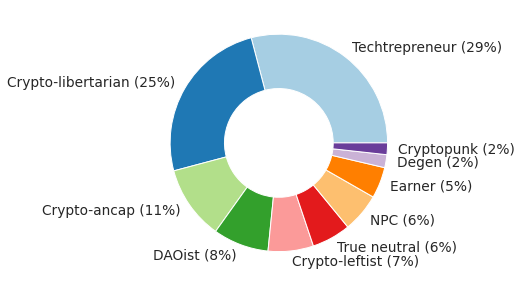

In [15]:
# Pie chart for overall faction assignments
plot_pie_faction('classification', df_results, colors=sns.color_palette("Paired"))

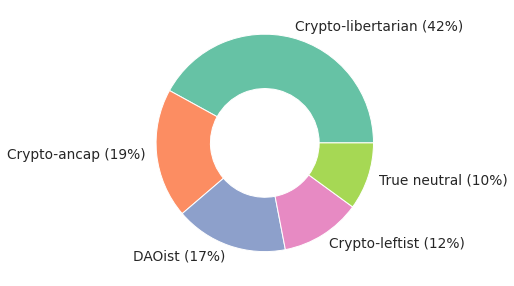

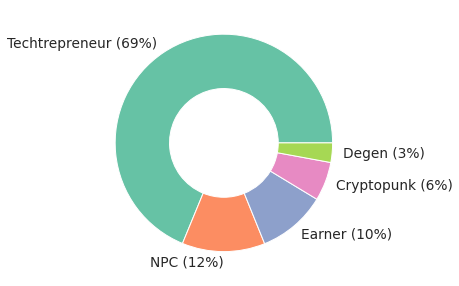

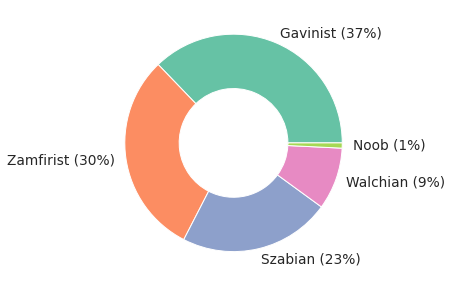

In [16]:
# Pie charts for specific dimensions of belief
for col in cols_results[1:]:
    plot_pie_faction(col, df_results)

### Correlation between faction/class assignments
Plot cross-tabulation and calculate corresponding [Cramer's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V), a measure of correlation between categorical variables.


Correlation: 0.089


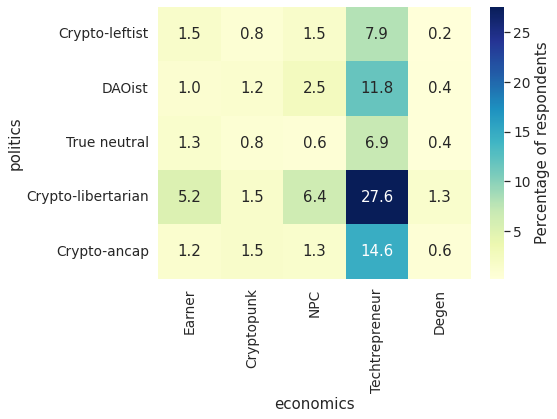

In [17]:
v = cramers_v(df_results['politics'], df_results['economics'], verbose=True)
print(f"\nCorrelation: {v:.3f}")


Correlation: 0.211


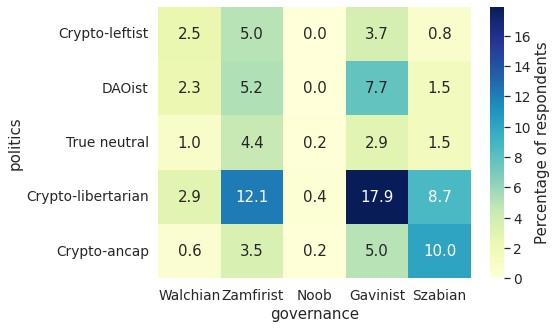

In [18]:
v = cramers_v(df_results['politics'], df_results['governance'], verbose=True)
print(f"\nCorrelation: {v:.3f}")


Correlation: 0.099


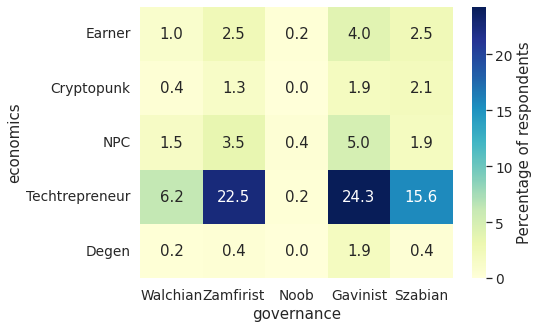

In [19]:
v = cramers_v(df_results['economics'], df_results['governance'], verbose=True)
print(f"\nCorrelation: {v:.3f}")

For politics-economics and economics-governance, the Cramer's V correlation values values are quite small (close to 0 on a 0 to 1 scale). **This indicates that these pairs of labels may suitably characterize two independent "axes" of belief.**

On inspection of the politics-governance cross-tabulation, **the proportion of crypto-ancaps who were Szabians (and vice versa) was higher than for the other faction combinations**. This makes sense given the aversion to centralized governance inherent in both of these labels.

## Distribution of responses to individual questions
-  What percentage of respondents chose each answer for each question? Reproduction of the plots from the live [Typeform response page](https://metagov.typeform.com/report/bz9SbjUU/ZY07qRfTs68oypzt) (as of 01/09/2022). Note that this excludes respondents who did not respond to the question.
- Are responses to individual questions correlated? This is an indication of whether the questions ask about distinct aspects of crypto beliefs.

In [20]:
def plot_cramers_v_matrix(df):
    """Plot heatmap of Cramer's V"""
    
    plt.figure(figsize=(8,8))
    fig = sns.heatmap(df, cmap=sns.color_palette("Blues", as_cmap=True), vmin=0, vmax=1, cbar_kws={'label': "Cramer's V"})
    fig.xaxis.set_ticks_position("top")
    fig.set_xticklabels(labels=df.columns, rotation=60)
    fig.set_aspect('equal')
    
    if SAVE:
        fname = f'{SAVEDIR}/cryptopolitics_question_correlation_matrix'
        plt.savefig(f'{fname}.svg', **kwargs_svg)
        plt.savefig(f'{fname}.png', **kwargs_png)

### What percentage of respondents chose each answer for each question? 

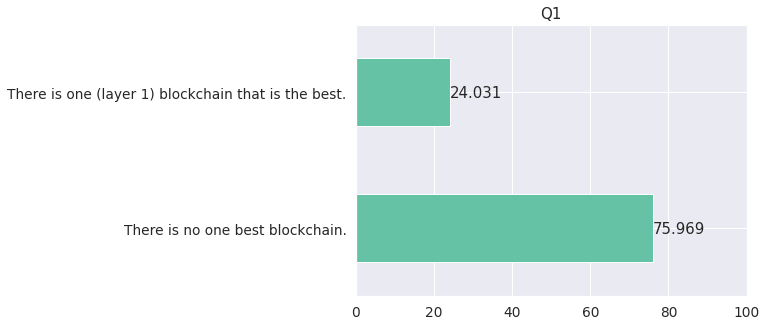

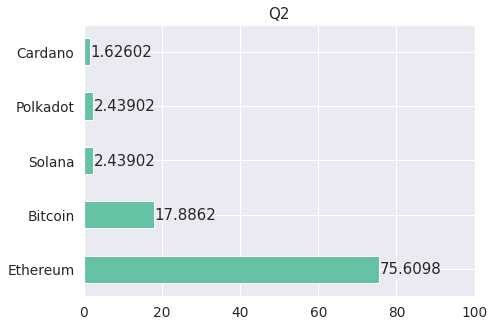

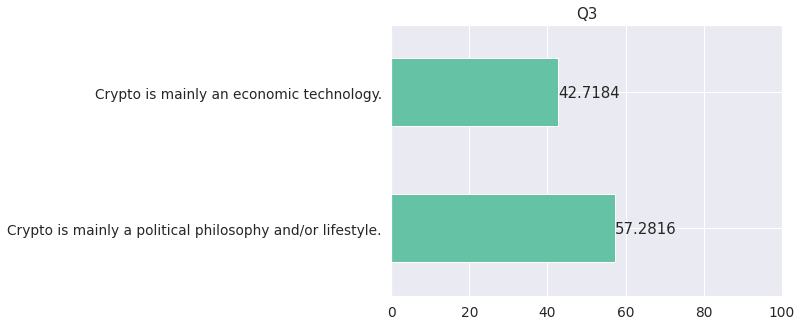

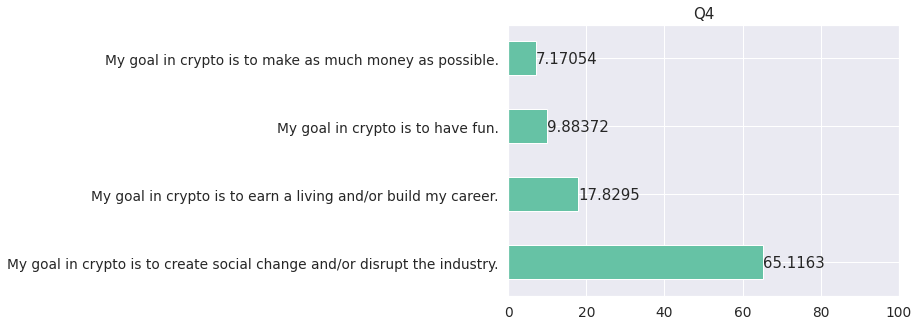

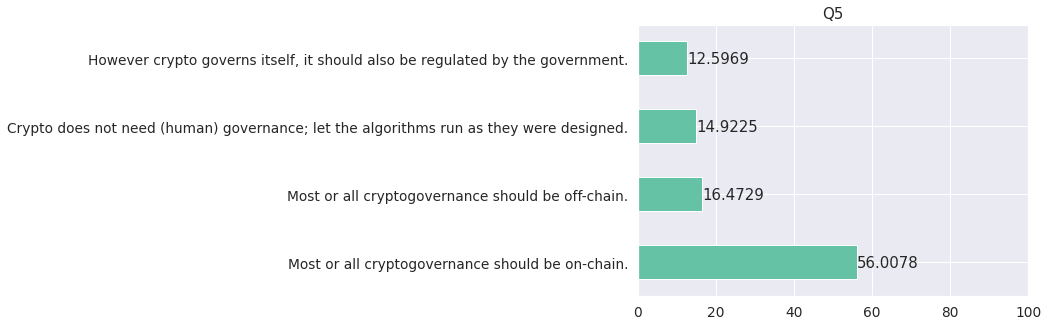

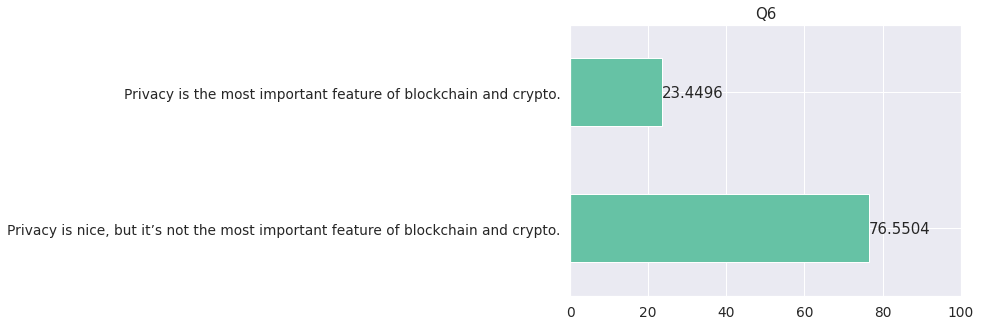

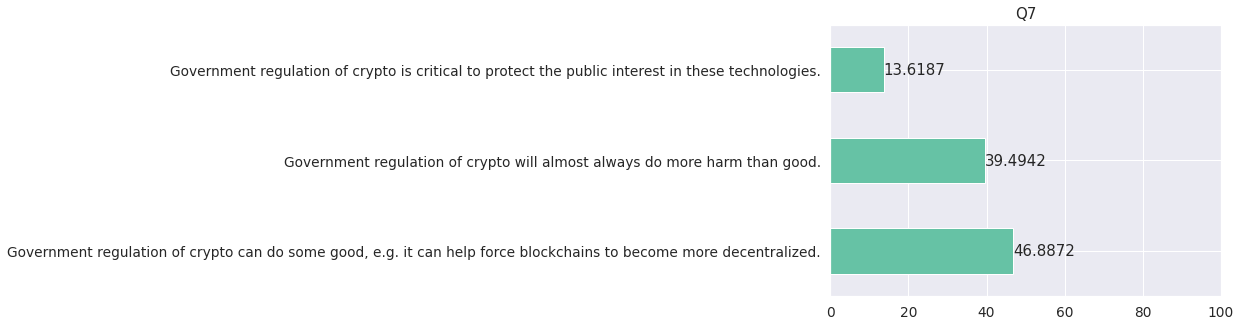

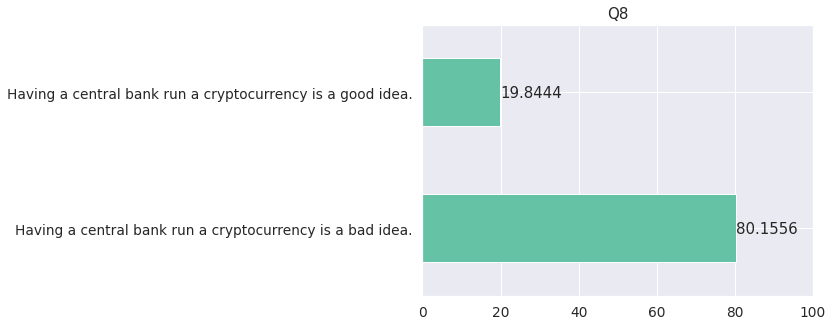

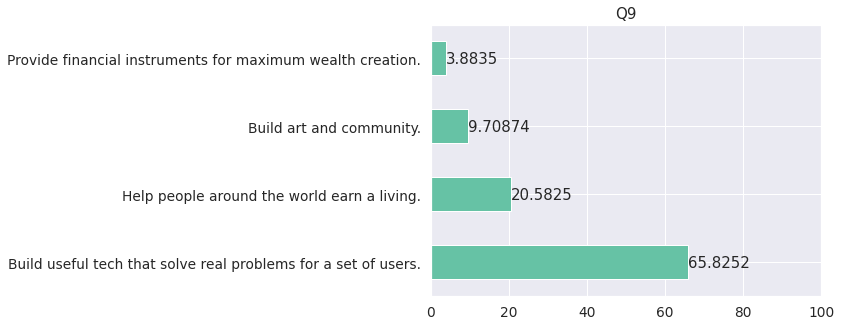

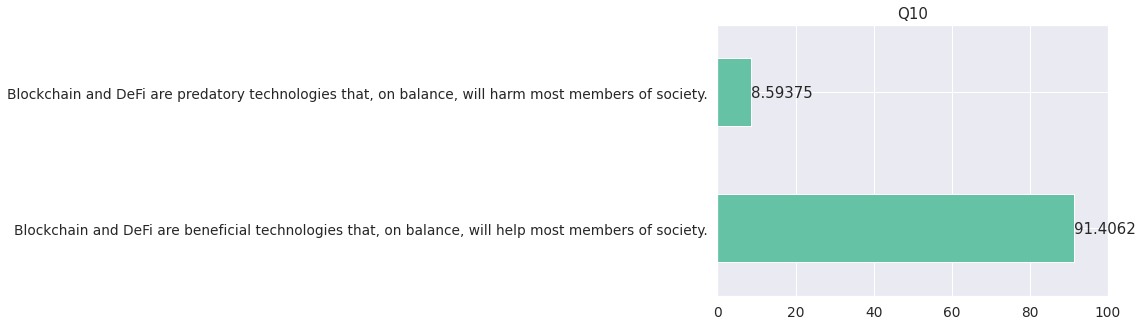

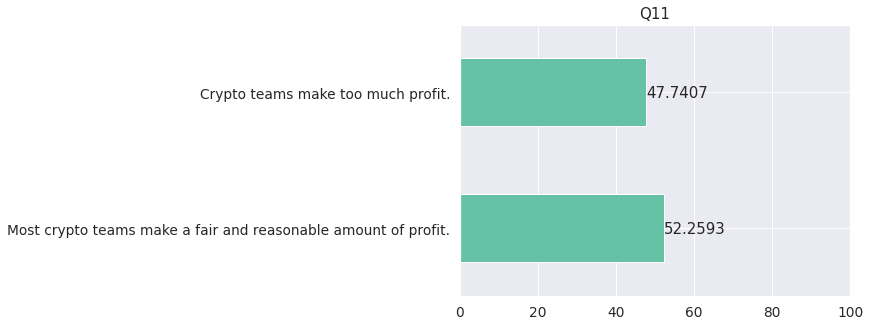

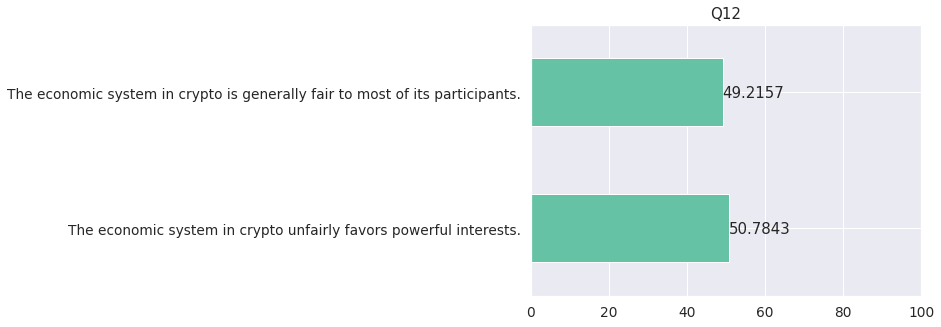

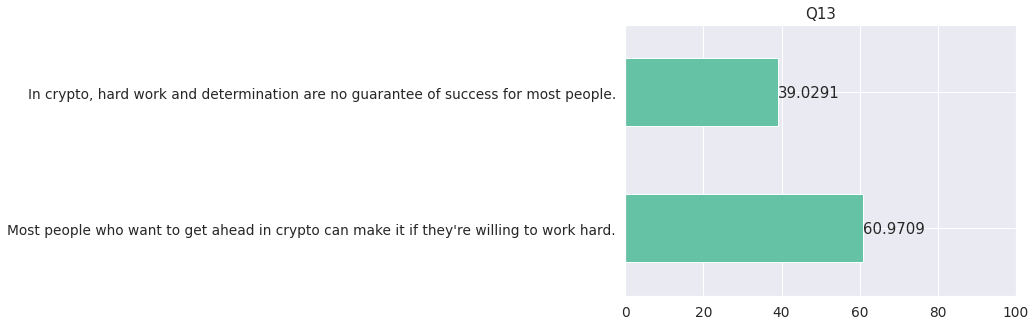

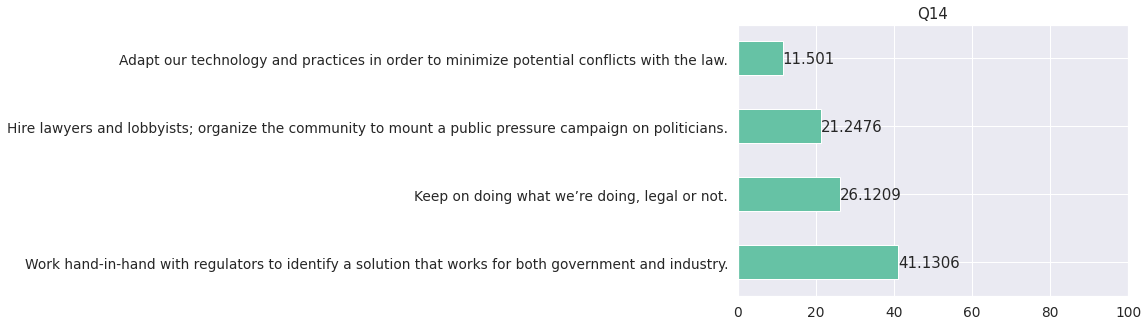

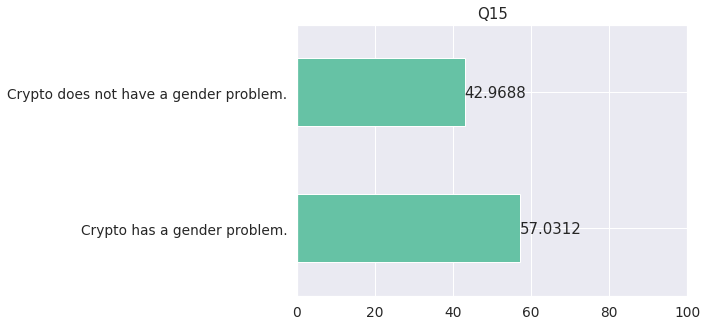

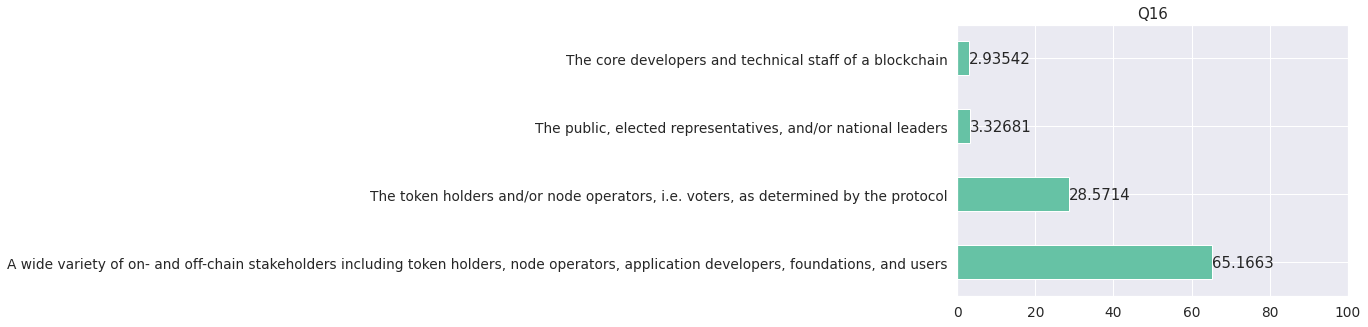

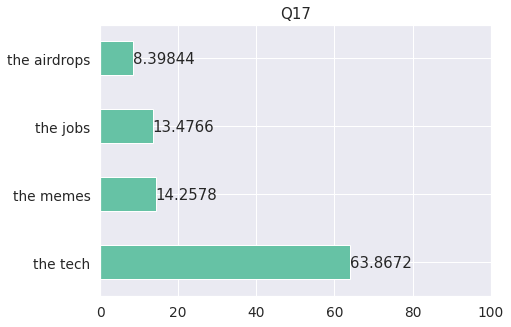

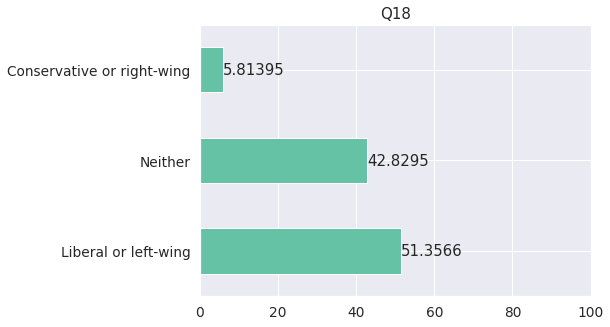

In [21]:
for col in cols_questions[:-1]:
    df_tmp = df_questions[col].value_counts(normalize=True)*100
    qnum = q2nDict[col]

    plt.figure()
    ax = df_tmp.plot.barh(title=f"Q{qnum}", xlim=(0,100), color=DEFAULT_COLOR)
    ax.bar_label(ax.containers[0])
    
    if SAVE:
        fname = f'{SAVEDIR}/cryptopolitics_Q{qnum}'
        plt.savefig(f'{fname}.svg', **kwargs_svg)
        plt.savefig(f'{fname}.png', **kwargs_png)

Notes of interest on these, as of 01/09/2022:
- **(Q3) A majority of respondents consider crypto to be mainly a political philosophy/lifestyle**, rather than mainly an economic technology. Note that this response was used to choose which of a respondent's political or economic faction was selected as their final classification.
- (Q4) Neary two thirds of respondents' primary goal is to create social change and/or disrupt the industry.
- (Q5, Q16) A majority of respondents believe most or all cryptogovernance should be on-chain; however, most also believe power should be distributed over a wide variety of on- and off-chain stakeholders. **Slight friction between these beliefs?**
- (Q6) For most respondents, privacy is not the most important feature of blockchains and crypto.
- **(Q7, Q14) Mixed opinions on government regulation of crypto** - most common response to Q7 is neutral; though most common response to Q14 is to work hand-in-hand with regulators, a majority of respondents prefer a more neutral or adversarial approach to legal oversight.
- (Q9, Q10) Majority sentiment is that to grow, crypto should build useful tech that solves real problems for a set of users; large majority believes blockchain and DeFi are beneficial technologies that, on balance, will help most members of society.
- **(Q11, Q12) Respondents are polarized on cryptoeconomics**, i.e., on whether crypto teams make a fair and reasonable amount of profit or too much profit, and whether the economic system in crypto is generally fair to most of its participants or unfairly favors powerful interest. Responses are split down the middle for both questions.

### Are responses to individual questions correlated?
For all pairs of questions, calculate the correlation Cramer's V, then plot the resulting correlation matrix.

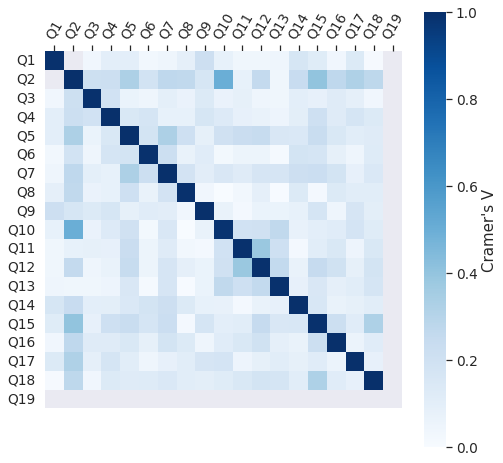

In [22]:
cramersMatrix = compute_cramers_v_matrix(df_questions)
df_cramer = pd.DataFrame(cramersMatrix, index=cols_questions, columns=cols_questions)
plot_cramers_v_matrix(df_cramer)

From a quick glance, most questions have little correlation with one another. One exception may be a correlation between Q2 ("Which blockchain is the best?") and some of the other questions; we explore this below, in the section on "Bitcoin versus Ethereum". 

Note that there is not any implication of significance (p-value) in these results. Grey boxes indicate uncomputable correlations (e.g., Q2 is only answered for one answer to Q1; responses to Q19 were lists).

## Bitcoin versus Ethereum
Are there any differences in responses and faction assignments between people affiliated with each of these ecosystems?

Note that these are not mutually exclusive groups!

In [23]:
# Select respondents who included an affiliation with Ethereum or Bitcoin
optCol = n2qDict[19]
df_tmp = df_questions[pd.notnull(df_questions[optCol])]
df_eth = df_tmp.loc[df_tmp[optCol].apply(lambda x: 'Ethereum' in x)].drop(columns=[optCol])
df_btc = df_tmp.loc[df_tmp[optCol].apply(lambda x: 'Bitcoin' in x)].drop(columns=[optCol])
print("Number of Ethereum affiliates: ", len(df_eth.index))
print("Number of Bitcoin affiliates:  ", len(df_btc.index))

Number of Ethereum affiliates:  366
Number of Bitcoin affiliates:   129


### Most common responses to each question, for each affiliation

In [24]:
def columns_where_rows_differ(df):
    """Get a list of the columns for which the row values differ."""
    
    return df.nunique(axis=0).where(lambda x: x>1, axis=0).dropna().index.tolist()

In [25]:
df_eth.mode()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18
0,There is no one best blockchain.,Ethereum,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto can do some go...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto unfairly favors ...,Most people who want to get ahead in crypto ca...,Work hand-in-hand with regulators to identify ...,Crypto has a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Liberal or left-wing


In [26]:
df_btc.mode()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18
0,There is no one best blockchain.,Bitcoin,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,"Keep on doing what we’re doing, legal or not.",Crypto does not have a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Neither


In [27]:
print(f"Questions for which Bitcoin and Ethereum respondents had different mode responses:\n\t",
      ", ".join(columns_where_rows_differ(pd.concat([df_eth.mode(), df_btc.mode()]))))

Questions for which Bitcoin and Ethereum respondents had different mode responses:
	 Q2, Q7, Q12, Q14, Q15, Q18


Differences between these groups are in questions **7 (government regulation)**, **12 (fairness of profit)**, **14 (government regulation)**, **15 (gender)**, and **18 (political affiliation)**.

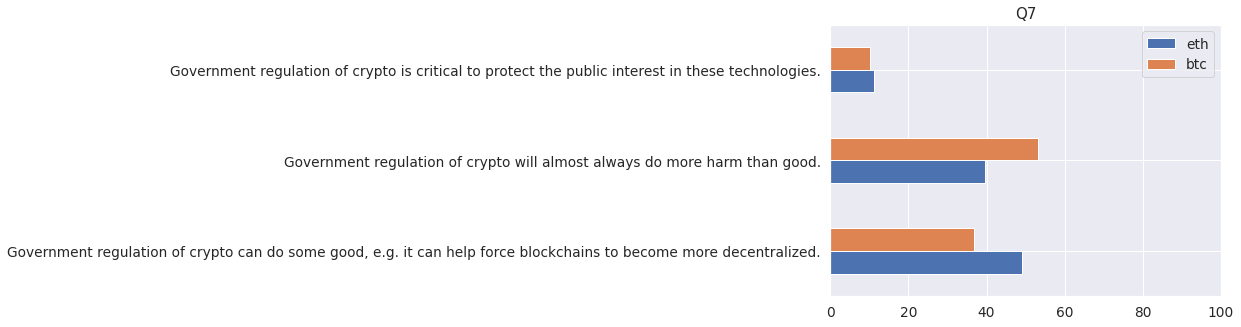

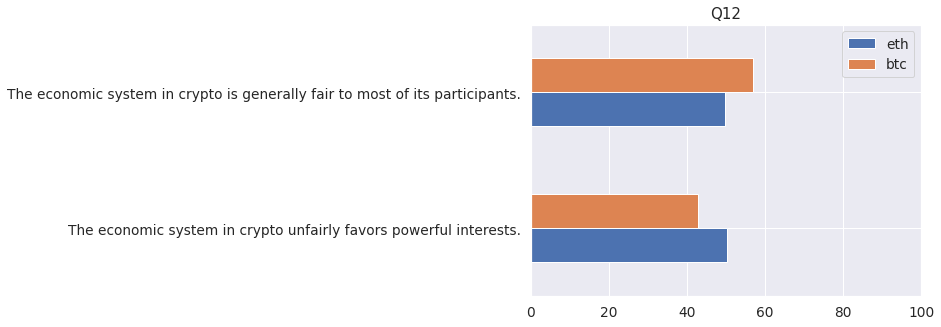

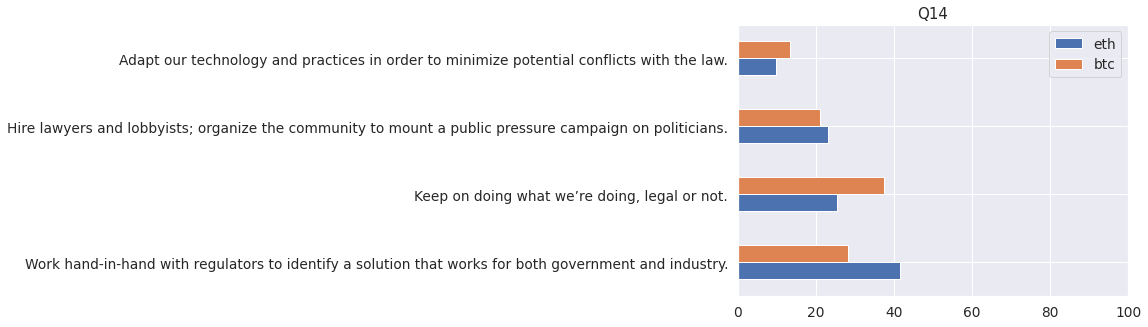

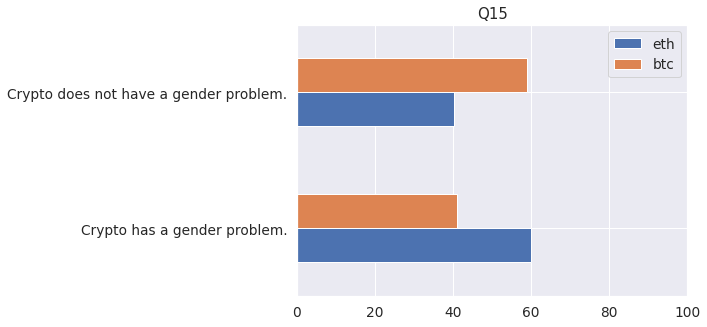

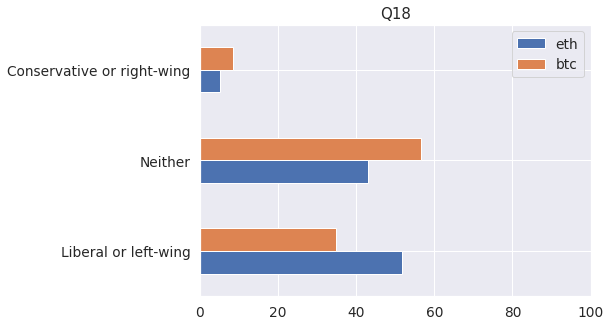

In [28]:
# Plot these differences in responses
for val in [7, 12, 14, 15, 18]:
    df_tmp = pd.DataFrame()
    for ecosys, df in {'eth': df_eth, 'btc': df_btc}.items():
        df_tmp[ecosys] = df[n2qDict[val]].value_counts(normalize=True)*100    

    ax = df_tmp.plot.barh(title=n2qDict[val], xlim=(0,100))

    if SAVE:
        fname = f"{SAVEDIR}/crytopolitics_btc-v-eth_Q{val}"
        plt.savefig(f"{fname}.png", **kwargs_png)
        plt.savefig(f"{fname}.svg", **kwargs_svg)

### Differences in distribution of assigned factions

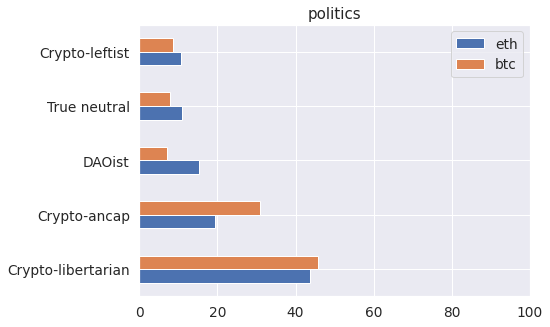

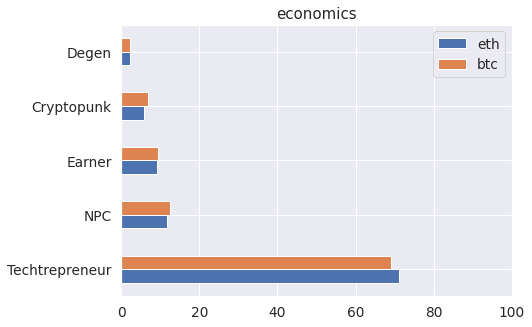

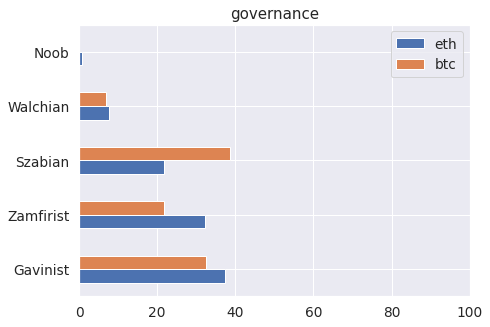

In [29]:
# Plot differences in assigned factions/classes
for col in cols_results[1:]:
    df_tmp = pd.DataFrame()
    for ecosys, df in {'eth': df_eth, 'btc': df_btc}.items():
        df_r = df_results[df_results.index.isin(df.index)]
        df_tmp[ecosys] = df_r[col].value_counts(normalize=True)*100    

    ax = df_tmp.plot.barh(title=col, xlim=(0,100))
    
    if SAVE:
        fname = f"{SAVEDIR}/crytopolitics_btc-v-eth_{col}"
        plt.savefig(f"{fname}.png", **kwargs_png)
        plt.savefig(f"{fname}.svg", **kwargs_svg)

## Feature selection, dimensionality reduction, and clustering
We built the initial set of factions by hand, but we were curious whether other factions and features might arise naturally from the data. To look for these, we used clustering methods (e.g. affinity propagation, agglomerative clustering) and feature selection methods (e.g. PCA, feature agglomeration). The hope was to identify and describe clusters of responses (or groupings of questions) in a meaningful way.

While the results are currently inconclusive (no clearly meaningful clusters), we include them here for reference. Let us know if you have questions or suggestions!

Steps involved:
- **Preprocessing** (how to encode the data)
- **Feature selection** (to find which questions most explain variance between respondents) and **dimensionality reduction** (to visualize the clusters; could also be a preprocessing step), i.e., grouping the questions by the responses
- **Clustering** (to find groups of similar respondents), i.e., grouping the responses by the questions

General process notes:
- For many clustering methods, the **distance** or **affinity** metric chosen greatly affects the resulting fit. Since ultimately this data is categorical, wherever there was the option, "manhattan" (cityblock) distance was chosen.

### Preprocessing
- Drop questions relating to specific ecosystems (Q2, Q19)
- Drop rows with any unanswered questions
- **Encode the data** in two ways:
    - **Categorical**: All questions one-hot encoded (49 columns)
    - **Mixed**: All but four categorical questions mapped to ordinal values on -1 to 1 scale, with the remaining questions one-hot encoded (29 columns). The one-hot encoded values are rescaled to reduce their weight relative to the ordinal encoded questions, since each question was split up into four features. *Warning*: this ordinal mapping, done subjectively, greatly affects subsequent results! See the .csv file for the mapping definition.

In [30]:
# Preprocessing
df_tmp = df_questions.copy().drop(columns=[n2qDict[2], n2qDict[19]])
df_to_cluster = df_tmp.dropna()
cols_questions_clustering = cols_questions.copy()
cols_questions_clustering.remove(n2qDict[2])
cols_questions_clustering.remove(n2qDict[19])

In [31]:
# Import ordinal mapping from file
df_map = pd.read_csv('data/cryptopolitics_quiz_cluster_mapping.csv')
gb_map = df_map.groupby('Question')

# Convert to dictionary
mappingDict = {}
for key, value in gb_map:
    
    df_q = gb_map.get_group(key)
    questionDict = {}
    for i, row in gb_map.get_group(key).iterrows():
        try:
            m = float(row['Mapping'])
        except ValueError:
            m = row['Mapping']
        questionDict[row['Answer']] = m
    
    mappingDict[key] = questionDict

# Rename dictionary items for ease of working with it
mappingDict = {n2qDict[k]: v for (k, v) in mappingDict.items()}

# Get mapped version of full response DataFrame
df_mapped = df_to_cluster.copy()
for col in df_mapped.columns:
    df_mapped[col] = df_mapped[col].map(mappingDict[col])

print("Mixed ordinal and categorical encoding of the data:")
df_mapped.head()

Mixed ordinal and categorical encoding of the data:


,Q1,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18
id,,,,,,,,,,,,,,,,,
449,1.0,-1.0,B,0.333,1.0,1.0,-1.0,A,1.0,-1.0,-1.0,-1.0,-1.000,1.0,B,A,0.0
256,-1.0,-1.0,C,-0.333,1.0,1.0,-1.0,B,1.0,-1.0,-1.0,1.0,0.333,1.0,B,C,-1.0
457,1.0,-1.0,C,0.333,1.0,1.0,-1.0,D,1.0,-1.0,-1.0,1.0,-0.333,-1.0,B,C,-1.0
512,-1.0,1.0,C,-1.000,-1.0,0.0,-1.0,C,1.0,-1.0,1.0,-1.0,1.000,1.0,C,C,-1.0
321,-1.0,1.0,D,1.000,-1.0,1.0,-1.0,C,1.0,-1.0,-1.0,-1.0,-1.000,-1.0,C,C,0.0


#### Categorical encoding (one-hot)

In [32]:
# Encode categorical questions as one-hot
v = DictVectorizer(sparse=False)
cols_categorical = [n2qDict[x] for x in [4,9,16,17]]
X_categorical = v.fit_transform(df_mapped[cols_categorical].to_dict(orient='records'))
df_categorical = pd.DataFrame(X_categorical, columns=v.get_feature_names_out())

# Rescale one-hot columns
# This must be set manually based on the coded values!
scaleBy = 0.5 # ordinal_range*(1/n_possible_responses) = (1-(-1))*(1/4); assumes both are constant across questions
df_categorical = df_categorical.multiply(scaleBy) 

# Merge with ordinal to create mixed ordinal-categorical data
df_ordinal = df_mapped.drop(columns=cols_categorical)
df_mixed = pd.concat([df_ordinal.reset_index(drop=True), df_categorical], axis=1)
X_mixed = df_mixed.to_numpy()

df_mixed.shape

(470, 29)

#### Mixed encoding (ordinal and categorical)

In [33]:
# Encode all questions as one-hot (only categorical data)
v = DictVectorizer(sparse=False)
X_allCat = v.fit_transform(df_to_cluster.to_dict(orient='records'))
df_allCat = pd.DataFrame(X_allCat, columns=v.get_feature_names_out())

df_allCat.shape

(470, 48)

### Feature selection and dimensionality reduction
 
Here, we might hope to find axes that correspond to something like the "politics" or "economics" axes defined in the survey, or some other belief/value axis not yet identified. These would allow us to view (and even cluster) the data as projected onto these axes.
    
- **PCA (principal component analysis)** (mixed encoding only)
- **Feature agglomeration**

An alternative method that could be relevant here is multiple correspondence analysis.

In [34]:
def scatter_plot_combos(X, N, colors=None, title=''):
    """Given X with shape (n_samples, n_dimensions) where n_dimensions may be >2,
    plot each combination of dimensions as a 2D scatter plot, with colors optionally specified"""
    
    color = DEFAULT_COLOR
    if colors is not None:
        color = colors
    if title != '':
        title = title + ': '
    
    for combo in list(combinations(list(range(N)), 2)):
        plt.figure()
        plt.scatter(X[:,combo[0]], X[:,combo[1]], color=color)
        plt.xlabel(combo[0])
        plt.ylabel(combo[1])
        plt.title(f"{title}n_components = {N} {combo}")

#### PCA
Besides providing a set of axes on which to project the data for visualization, the first few PCA components could help us understand which questions are most important in explaining variance between respondents. An important caveat: since PCA assumes numerical data, the component values do not correspond exactly to possible encoded answer values. By snapping these values to the nearest possible answer, we can get an approximation of this.

In [35]:
def compute_and_plot_pca(X, N, labels=None):
    """Compute and plot PCA transformation of data"""
    
    # Transform
    pca = PCA(n_components=N)
    X_transformed = pca.fit_transform(X)

    print(f"Total variance explained by {N} components: {100*sum(pca.explained_variance_ratio_):.1f}%")    
    
    # Display PCA vectors against one another
    df_tmp = pd.DataFrame(np.transpose(pca.components_))
    if labels is not None:
        df_tmp.index = labels
    if len(df_tmp.columns) > 3:
        df_tmp = df_tmp.iloc[:, :3]
    df_tmp.plot.bar(width=0.8, figsize=(12,6))
    plt.ylabel('Component value\n(note: scale for ordinal is different from that of categorical)')

    # Print "nearest possible" response value for the first three PCA components
    df_tmp2 = (snap_to_nearest_value(df_tmp.transpose())).transpose()
    print(f"Questions for which the components had different nearest-possible responses:\n\t",
      ", ".join(columns_where_rows_differ(df_tmp2.transpose())))
    
    if SAVE:
        # Save original and closest-possible-response versions of results for interpretation
        df_tmp.to_csv(f"{SAVEDIR}/cryptopolitics_pca.csv")
        df_tmp2.to_csv(f"{SAVEDIR}/cryptopolitics_pca_snapto.csv")
    
    # Scree plot
    plt.figure()
    plt.plot(np.arange(pca.n_components_) + 1, 100*pca.explained_variance_ratio_,
             'o-', linewidth=2, color=DEFAULT_COLOR)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained (%)')
    plt.show()

    # Plot
    scatter_plot_combos(X_transformed, min(N, 3), title='PCA')

    return X_transformed, pca

In [36]:
def snap_to_nearest_value(df):
    """For use with PCA or other vectors that do not correspond exactly to possible answer values.
    
    This is used to help understand which specific questions/responses may play the largest role
    in explaining variance between respondents"""
    
    TOL = 0.85 # How close is "close enough" to a possible response? 0 = exact match.
    MAX_VAL = 0.5 # Assuming Really should 
    
    df_snapto = df.copy()
    for i, row in df.iterrows():
        for col in df.columns:
            qnum = col
            if '=' in col:
                qnum, _ = col.split('=')
            val = row[col]
                
            valsList = sorted(mappingDict[qnum].values())

            if '=' not in col:
                # Method for ordinal values
                valsSpan = valsList[-1] - valsList[0]
                nVals = len(valsList)
                nearestVals = [x for x in valsList if abs(x - val) < TOL*((valsSpan/2)/(nVals-1))]
                if len(nearestVals) == 0:
                    snap_to = np.nan
                else:
                    snap_to = nearestVals[0]
                    if len(nearestVals) > 1:
                        print(f"col {col} has more than one nearest value, i.e., fix your formula!")
            else:
                # Method for categorical values
                if abs(MAX_VAL - val) < TOL*MAX_VAL/2:
                    snap_to = MAX_VAL
                else:
                    snap_to = 0
            
            df_snapto.at[i, col] = snap_to
            
    return df_snapto

Total variance explained by 17 components: 98.3%
Questions for which the components had different nearest-possible responses:
	 Q3, Q5, Q14, Q15


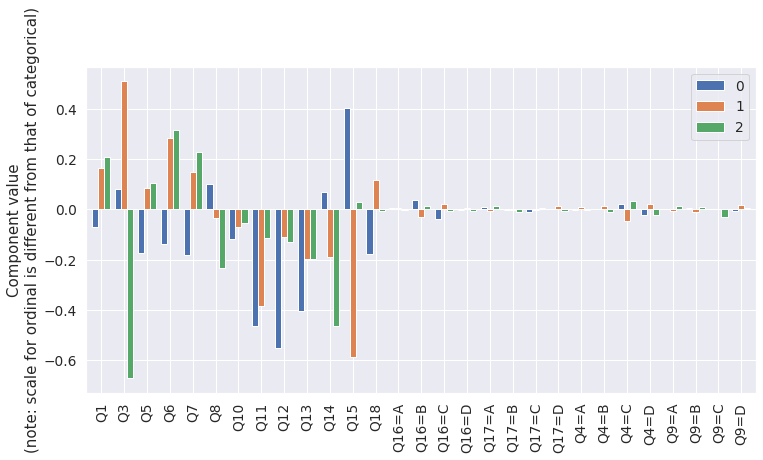

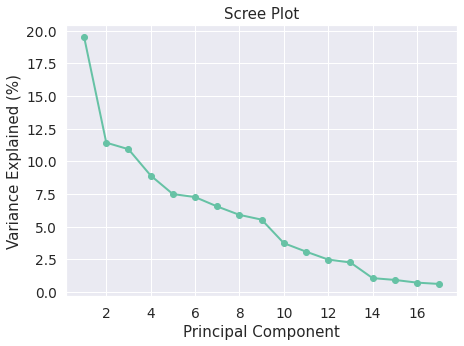

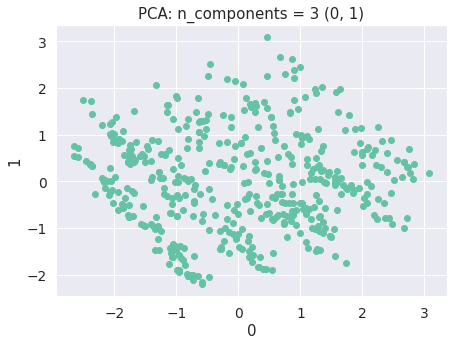

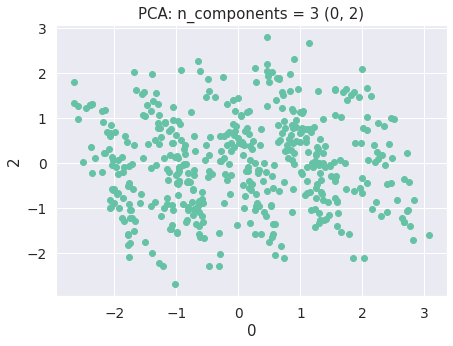

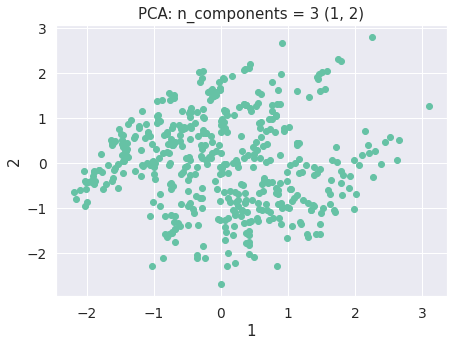

In [37]:
# PCA on mostly-ordinal data (not really meaningful for one-hot-encoded data)
# Display only first three components for convenience. Later on in the notebook, 
# any subset of these components can be selected.

n_PCA = 17 # Number of questions included in this analysis
X_pca, pca_result = compute_and_plot_pca(X_mixed, n_PCA, labels=list(df_mixed.columns))

Based on the PCA component values, Q3, Q5, Q14 (government regulation), Q15 (gender) may play the greatest role in differentiating respondents. However, the variance explained by the first 2-3 components is fairly low (less than 50%), so these results are pretty weak.

Even so, we'll use these components to visualize the clustering later.

#### Feature agglomeration

In [38]:
def compute_and_plot_feature_agglomeration(X, N, labels=None, kwargs={}):
    """Compute and plot feature agglomeration transformation of data
    
    Choice of distance metric is very important!"""
    
    # Transform
    fa = FeatureAgglomeration(n_clusters=N, **kwargs) #cosine, cityblock, hamming, dice
    X_transformed = fa.fit_transform(X)

    # Display some results
    if labels is not None:
        features = pd.DataFrame([{'question': labels[i], 'feature': x} for (i, x) in enumerate(fa.labels_)])
        gb = features.groupby(by='feature')
        for key, item in gb:
            print(gb.get_group(key), "\n\n")
    
    # Plot
    scatter_plot_combos(X_transformed, N, title=f'Feature Agglomeration ({kwargs})')

    return X_transformed, fa

In [39]:
kwargs_fa_allCat = {'affinity': 'manhattan', 'linkage': 'complete'}
kwargs_fa_mixed = {'affinity': 'manhattan', 'linkage': 'complete'}#{'affinity': 'cosine', 'linkage': 'single'}

                                             question  feature
0   Q10=Blockchain and DeFi are beneficial technol...        0
3   Q11=Most crypto teams make a fair and reasonab...        0
4   Q12=The economic system in crypto is generally...        0
7   Q13=Most people who want to get ahead in crypt...        0
14  Q16=A wide variety of on- and off-chain stakeh...        0
21                                       Q17=the tech        0
25                Q1=There is no one best blockchain.        0
27  Q3=Crypto is mainly a political philosophy and...        0
29  Q4=My goal in crypto is to create social chang...        0
36  Q5=Most or all cryptogovernance should be on-c...        0
37  Q6=Privacy is nice, but it’s not the most impo...        0
42  Q8=Having a central bank run a cryptocurrency ...        0
45  Q9=Build useful tech that solve real problems ...        0 


                                             question  feature
1   Q10=Blockchain and DeFi are predatory technolo..

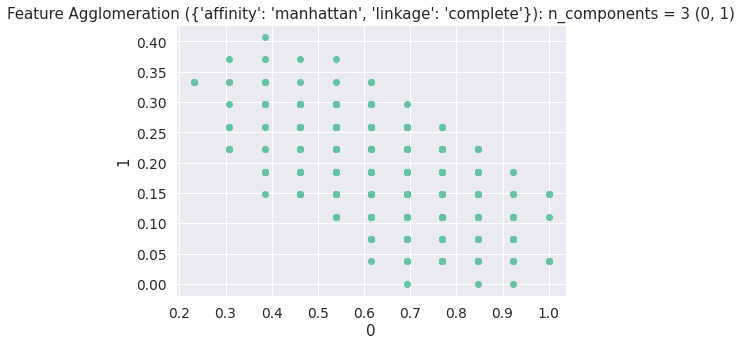

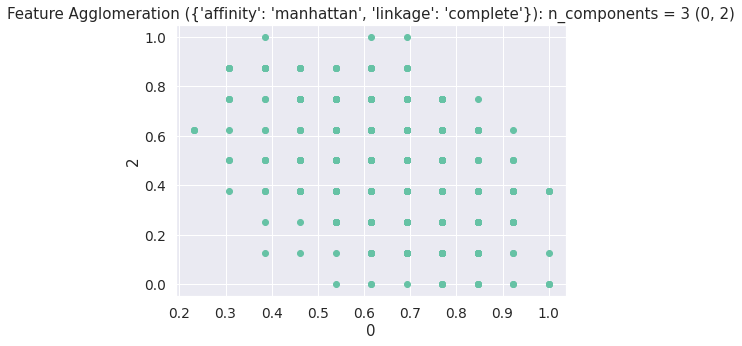

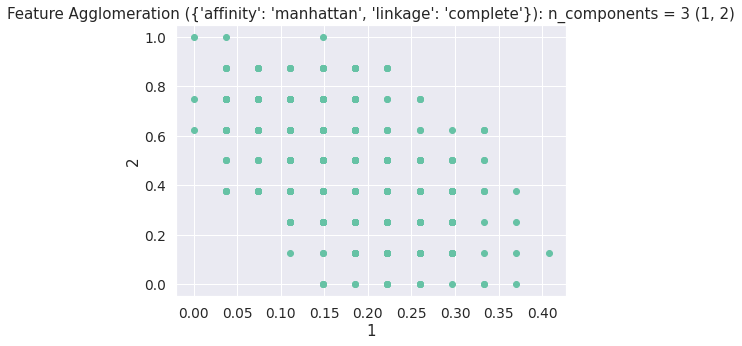

In [40]:
# Feature agglomeration on categorical data - 4 features
X_fa_allCat, fa_result_allCat = compute_and_plot_feature_agglomeration(X_allCat, 3,
                                                                       labels=df_allCat.columns,
                                                                       kwargs=kwargs_fa_allCat)

The features grouped with this method could have some relation to the politics/economics/governance question groups we defined for the faction assignments. Next time around, could programmatically compare the two sets of groupings. 

   question  feature
0        Q1        0
1        Q3        0
3        Q6        0
5        Q8        0
10      Q14        0
11      Q15        0
12      Q18        0 


   question  feature
2        Q5        1
4        Q7        1
6       Q10        1
7       Q11        1
8       Q12        1
9       Q13        1
13    Q16=A        1
14    Q16=B        1
15    Q16=C        1
16    Q16=D        1
17    Q17=A        1
18    Q17=B        1
19    Q17=C        1
20    Q17=D        1
21     Q4=A        1
22     Q4=B        1
23     Q4=C        1
24     Q4=D        1
25     Q9=A        1
26     Q9=B        1
27     Q9=C        1
28     Q9=D        1 




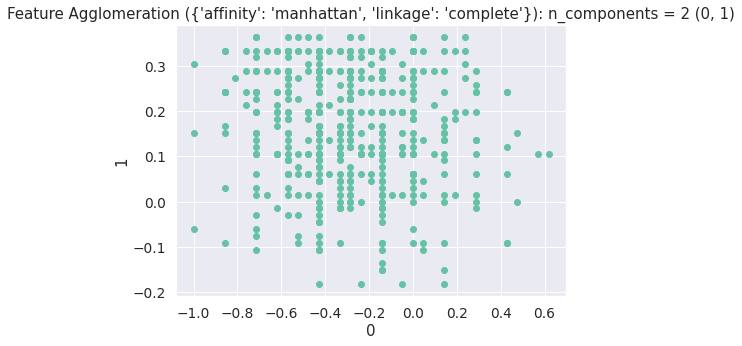

In [41]:
# Feature agglomeration on mixed data - 2 features
X_fa_mixed, fa_result_mixed = compute_and_plot_feature_agglomeration(X_mixed, 2, 
                                                                     labels=df_mixed.columns,
                                                                     kwargs=kwargs_fa_mixed)

The features grouped with this method could also have some relation to the politics/economics/governance question groups we defined for the faction assignments. A quick glance through our own mapping shows that the questions we indicated as related to the economics were all labeled as Feature 1, though the politics and governance questions were scattered across the two features.

We'll use these two sets of results to visualize the clustering later.

### Clustering/group responses by questions
Some methods allow a choice of how many clusters to find. If the clusters correspond to anything like the defined factions, there may be ~4 clusters for ~2 orthgonal "sentiment" axes --> 16 total clusters (e.g., compare w/politics-economics cross-tabulation), but of very different sizes. 
  
- **K-means**: The imposed constraint of equal cluster sizes may not be suitable for this data. However, K-modes clusters corresponding to a representative set of answers is nice.
- **Affinity propagagion**: Has the benefit of interpretability of "exemplar" sample, doesn't impose equal cluster sizes, and doesn't require a choice of clusters. 
- **Agglomerative clustering**: Starts with individual responses and agglomerates responses hierarchically by "distance". This could help identify subgroups within larger schools of thought. 

In [42]:
# In case a lot of clusters are found
COLORS = np.array(sns.color_palette('bright').as_hex() + \
                  sns.color_palette('pastel').as_hex() + \
                  sns.color_palette('dark').as_hex() + \
                  sns.color_palette('muted').as_hex())

#### K-means (really, K-modes and K-Prototypes)
Since this data is categorical/ordinal rather than numerical, we have two alternatives to regular K-means: 
1. Categorical: [K-modes](https://pypi.org/project/kmodes/) clustering
2. Mixed: K-prototypes clustering

In [43]:
def k_clustering_sweep(responseMatrix, kMax=20, method=KModes, kwargs={}):
    """Find clusters using method (KModes or KPrototype)
    Sweep from k=1 to k=kMax and plot resulting cost to evaluate which k may be most useful"""
    
    costMatrix = []
    kValues = list(np.arange(1, kMax+1))
    clusterCentroids = {}
    for k in range(1, kMax+1):
        # Fit and predict clusters, then save centroids and cost
        clusters = method(n_clusters=k, n_init=20)
        clusters.fit_predict(responseMatrix, **kwargs)
        costMatrix.append(clusters.cost_)
        clusterCentroids[k] = clusters.cluster_centroids_
    
    # Plot result of sweep
    plt.plot(kValues, np.divide(costMatrix, max(costMatrix)), color=DEFAULT_COLOR)
    plt.xlabel("k")
    plt.ylabel("cost")
    
    return clusterCentroids

##### Categorical

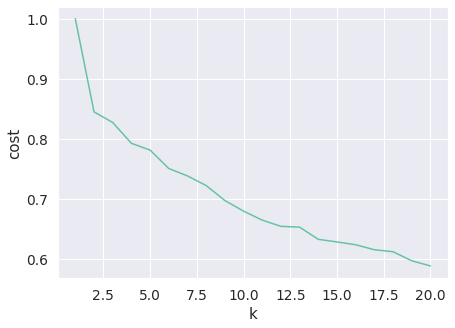

In [44]:
clusterCentroids = k_clustering_sweep(df_to_cluster.to_numpy())

Looks like we've got a bit of an elbow at two clusters, so let's see what the results look like for two clusters:

In [45]:
df_clusters = pd.DataFrame(clusterCentroids[2])
df_clusters.rename(columns={i: x for (i, x) in enumerate(cols_questions_clustering)}, inplace=True)
df_clusters

,Q1,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18
0,There is no one best blockchain.,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto can do some go...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Crypto teams make too much profit.,The economic system in crypto unfairly favors ...,Most people who want to get ahead in crypto ca...,Work hand-in-hand with regulators to identify ...,Crypto has a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Liberal or left-wing
1,There is no one best blockchain.,Crypto is mainly an economic technology.,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,"Keep on doing what we’re doing, legal or not.",Crypto does not have a gender problem.,"The token holders and/or node operators, i.e. ...",the tech,Neither


In [46]:
print(f"Questions for which the clusters had different mode responses:\n\t",
      ", ".join(columns_where_rows_differ(df_clusters)))

Questions for which the clusters had different mode responses:
	 Q3, Q7, Q11, Q12, Q14, Q15, Q16, Q18


##### Mixed

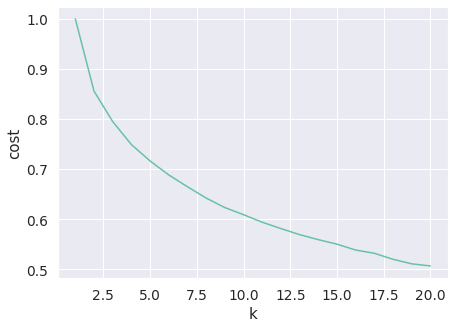

In [47]:
clusterCentroids_mapped = k_clustering_sweep(df_mapped.to_numpy(),
                                             method=KPrototypes,
                                             kwargs={'categorical': [2,7,14,15]})

It's not obvious to me that there's a particularly good number of clusters to stop at, so we'll leave it at that.

#### Affinity propagation

In [48]:
def run_affinity_propagation(X, kwargs={}, X_for_plotting=None, affinity=None):
    """Perform affinity propagation clustering using precomputed affinity"""
    
    if affinity is None:
        # Use default affinity (Euclidean)
        ap = AffinityPropagation()
        ap = ap.fit(X)
        clusters = ap.cluster_centers_
    else:
        # Compute affinities based on given distance metric
        assert affinity in ['manhattan', 'cosine'], "Choose one of 'manhattan' or 'cosine' affinity"
        
        ap = AffinityPropagation(affinity='precomputed')
        
        if affinity == 'manhattan':        
            X_distance = manhattan_distances(X)
            X_affinity = np.exp(-X_distance * (1/X.shape[1]))
        elif affinity == 'cosine':
            X_affinity = cosine_similarity(X)
            
        ap = ap.fit(X_affinity)  
        clusters = X[ap.cluster_centers_indices_]
    
    # Display info on clusters
    print(f"\tn_clusters: {len(clusters)}")
    pointCounts = np.bincount(ap.labels_)
    print(f"\tpoints per cluster: min = {min(pointCounts)}, max = {max(pointCounts)}, median = {int(np.median(pointCounts))}")

    # Plot on appropriate number of projected views (using provided projection, if any)
    colors =  np.array(list(islice(cycle(COLORS),int(len(clusters) + 1))))
    if X.shape[1] <= 3:
        scatter_plot_combos(X, X.shape[1], colors=colors[ap.labels_])
    elif X_for_plotting is not None:
        scatter_plot_combos(X_for_plotting, min(X_for_plotting.shape[1], 3), colors=colors[ap.labels_])
        
    return clusters, ap

##### Cluster original one-hot or ordinal encoded data

In [49]:
ap_affinity = 'manhattan' # Use this for both one-hot and ordinal encoded data. Another viable option could be "cosine"

Categorical:
	n_clusters: 55
	points per cluster: min = 3, max = 18, median = 8
Mixed:
	n_clusters: 49
	points per cluster: min = 4, max = 21, median = 9


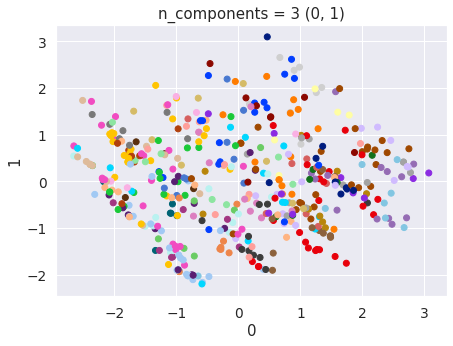

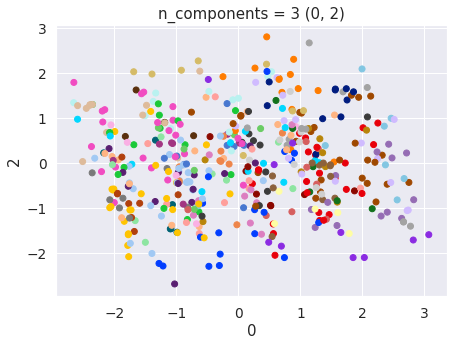

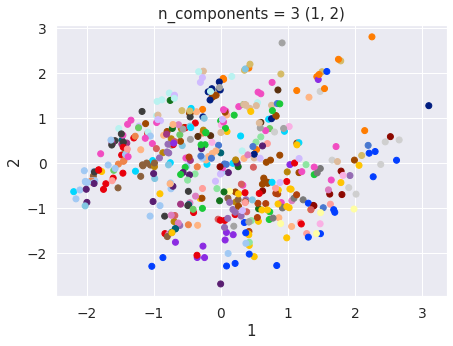

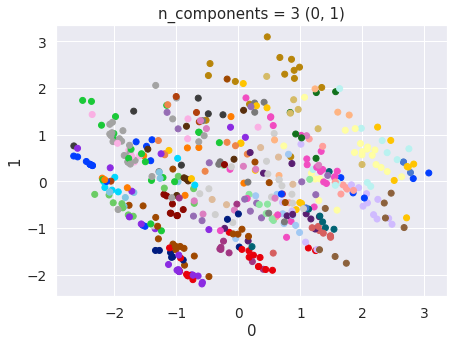

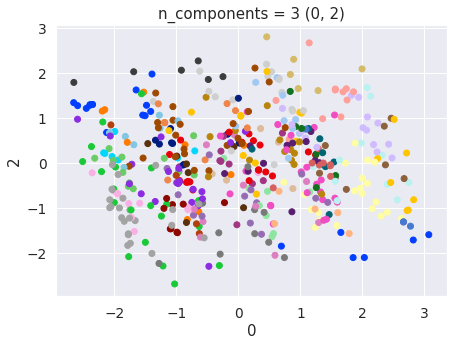

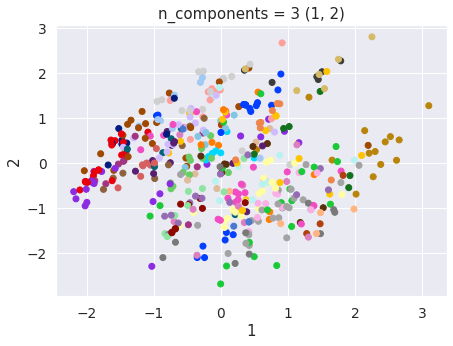

In [50]:
print("Categorical:")
clusters_ap_allCat, ap_allCat = run_affinity_propagation(X_allCat, X_for_plotting=X_pca, affinity=ap_affinity)
print("Mixed:")
clusters_ap_mixed, ap_mixed = run_affinity_propagation(X_mixed, X_for_plotting=X_pca, affinity=ap_affinity)

This is way too many clusters to draw any meaningful conclusions from. But... what if we cluster the clusters themselves? Do the exemplar points consolidate into distinct groupings?

Clustering on cluster centers... PCA projection
Categorical:
	n_clusters: 7
	points per cluster: min = 3, max = 13, median = 9
Mixed:
	n_clusters: 7
	points per cluster: min = 2, max = 11, median = 7


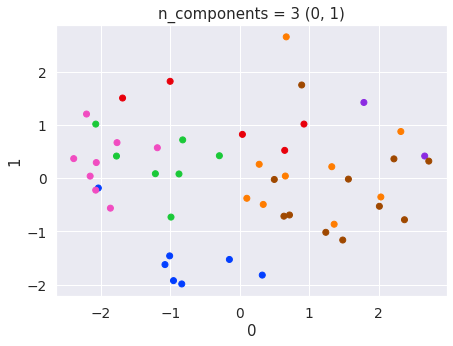

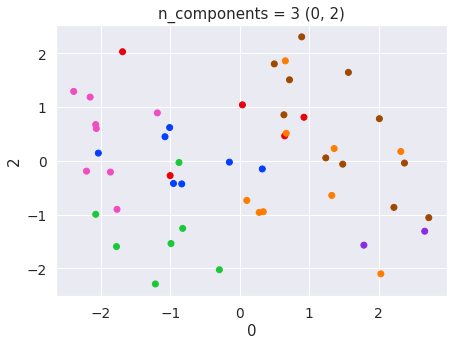

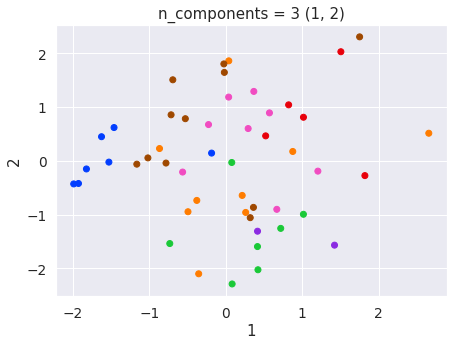

In [51]:
print("Clustering on cluster centers... PCA projection")
print("Categorical:")
clusters_meta_allCat, ap_meta_allCat = run_affinity_propagation(clusters_ap_allCat, affinity=ap_affinity)
print("Mixed:")
clusters_meta_mixed, ap_meta_mixed = run_affinity_propagation(clusters_ap_mixed,
                             X_for_plotting=pca_result.transform(clusters_ap_mixed),
                             affinity=ap_affinity)

Maybe... there is a lot of overlap between clusters though, at least on this projection. 

Clustering on cluster centers... FA projection
Categorical:
	n_clusters: 7
	points per cluster: min = 3, max = 13, median = 7
Mixed:
	n_clusters: 7
	points per cluster: min = 2, max = 11, median = 7


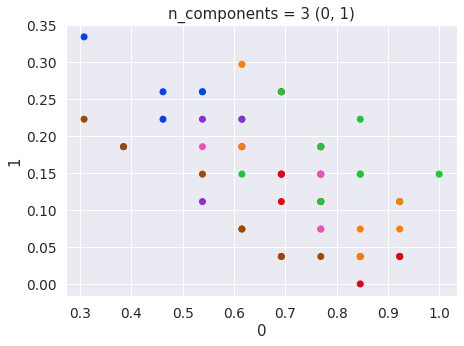

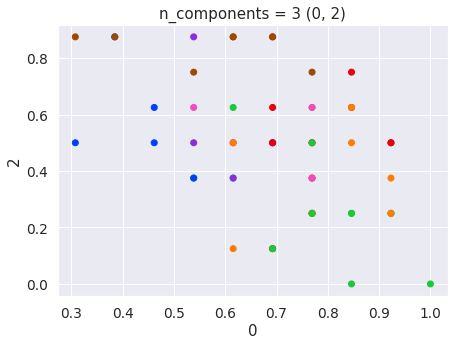

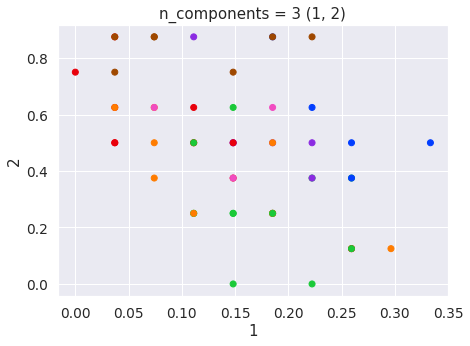

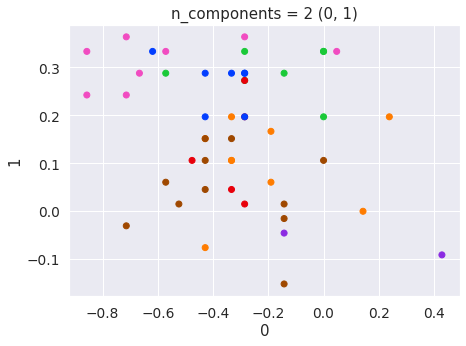

In [52]:
print("Clustering on cluster centers... FA projection")
print("Categorical:")
clusters_meta_allCat, ap_meta_allCat = run_affinity_propagation(clusters_ap_allCat, 
                                                                X_for_plotting=fa_result_allCat.transform(clusters_ap_allCat),
                                                                affinity=ap_affinity)
print("Mixed:")
clusters_meta_mixed, ap_meta_mixed = run_affinity_propagation(clusters_ap_mixed,
                             X_for_plotting=fa_result_mixed.transform(clusters_ap_mixed),
                             affinity=ap_affinity)

Changing the projection doesn't yield anything more insightful.

#### Agglomerative clustering

In [53]:
def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and plot the dendrogram
    
    Copied from scikit-learn example:
    https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
    """

    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis)")

In [54]:
def run_agglomerative_clustering(X, nClusters, kwargs={}, X_for_plotting=None):
    """Run agglomerative clustering"""
    
    ac = AgglomerativeClustering(compute_distances=True,
                                 n_clusters=nClusters,
                                 **kwargs)
    ac = ac.fit(X)
    y_predicted = ac.labels_.astype(int)

    # Display info on clusters
    print("number of points in each cluster: ", ", ".join([f"{i}: {str(x)}" for i, x in enumerate(np.bincount(ac.labels_))]))

    # Plot dendrogram of connections between clusters
    plt.figure()
    plot_dendrogram(ac, truncate_mode="lastp", p=nClusters) 

    # Plot on appropriate number of projected views (using provided projection, if any)
    if X_for_plotting is not None:
        scatter_plot_combos(X_for_plotting, min(X_for_plotting.shape[1], 3), colors=COLORS[y_predicted])
    else:
        scatter_plot_combos(X, min(X.shape[1], 3), colors=COLORS[y_predicted])

In [55]:
nClusters = 4 # Chosen for the number of (non-NPC-type) factions/classes in each dimension

number of points in each cluster:  0: 147, 1: 148, 2: 109, 3: 66
Mixed:
number of points in each cluster:  0: 132, 1: 81, 2: 137, 3: 120


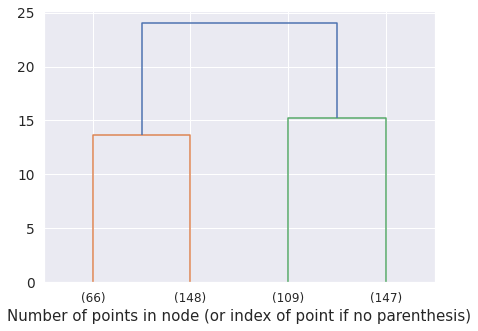

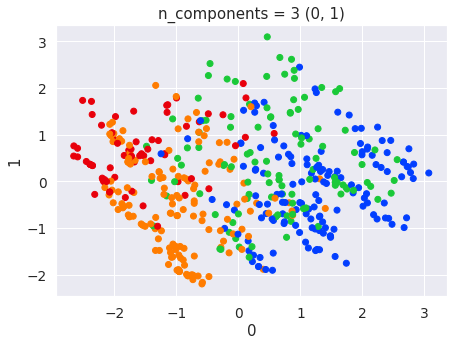

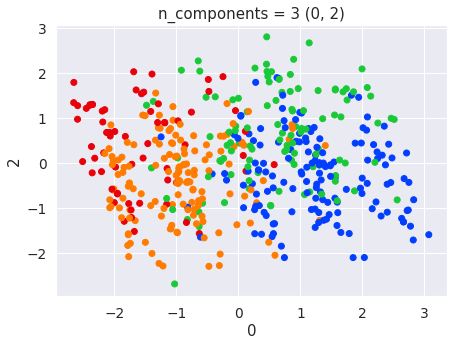

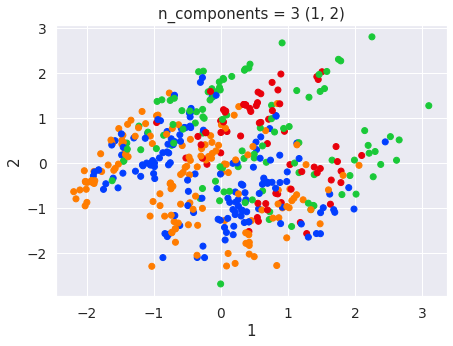

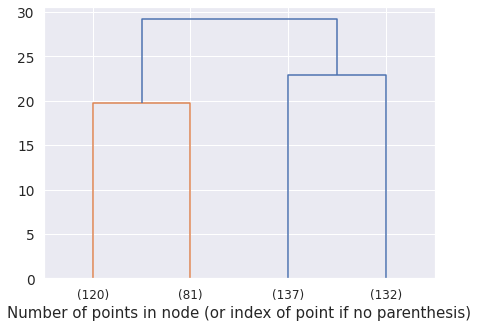

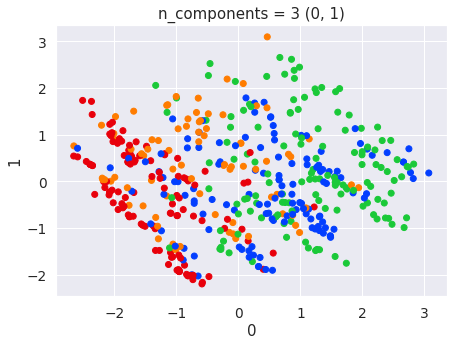

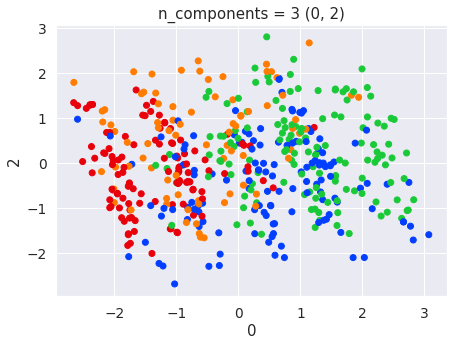

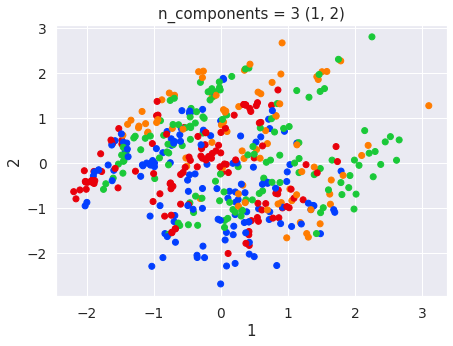

In [56]:
# PCA projection
run_agglomerative_clustering(X_allCat, nClusters, X_for_plotting=X_pca)
print("Mixed:")
run_agglomerative_clustering(X_mixed, nClusters, X_for_plotting=X_pca)

There is a lot of overlap between clusters, at least on this projection.

Categorical:
number of points in each cluster:  0: 147, 1: 148, 2: 109, 3: 66
Mixed:
number of points in each cluster:  0: 132, 1: 81, 2: 137, 3: 120


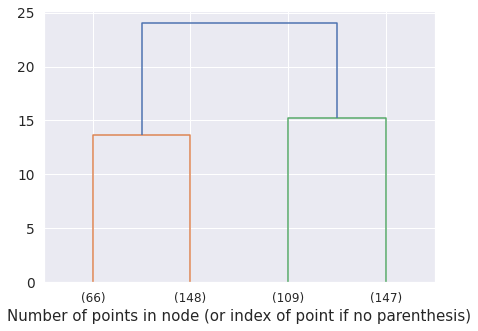

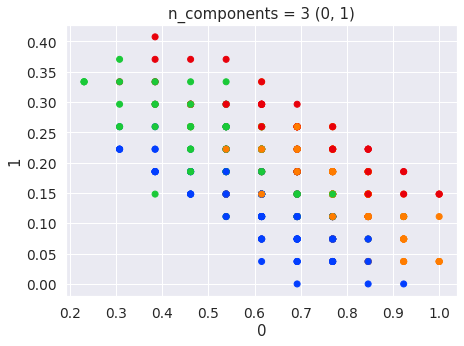

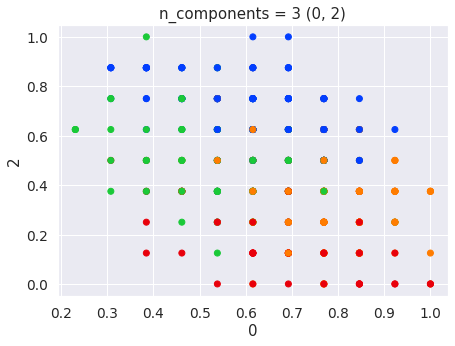

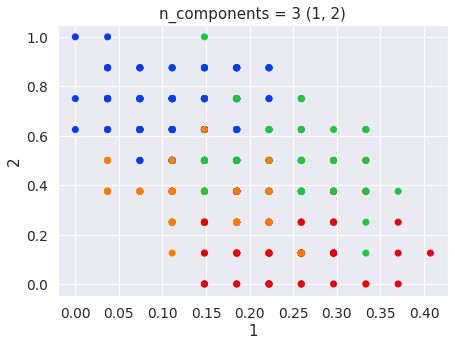

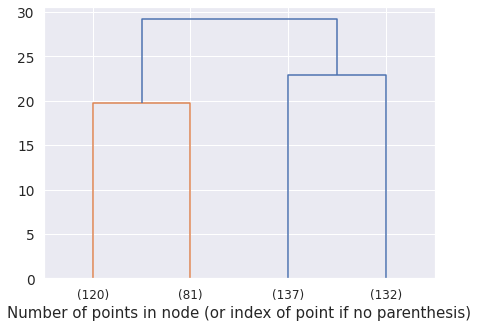

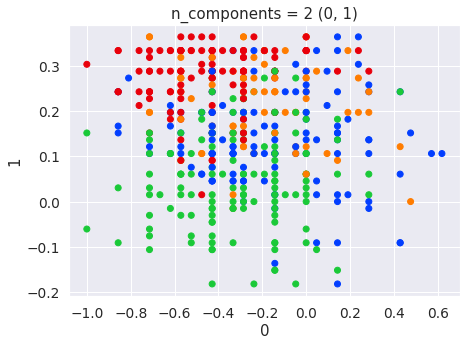

In [57]:
# Feature agglomeration projection
print("Categorical:")
run_agglomerative_clustering(X_allCat, nClusters, X_for_plotting=X_fa_allCat)
print("Mixed:")
run_agglomerative_clustering(X_mixed, nClusters, X_for_plotting=X_fa_mixed)

The clusters do seem somewhat more localized in the feature agglomeration categorical-data projection, but it's unclear to what extent they overlap (multiple points are plotted on top of one another).

##### Cluster lower-dimensional data

If any of the 2D embeddings corresponded to something like the politics-economics axes, we might expect there to be a handful of large clusters and lots of clusters with only a few points (compare w/crosstab).

number of points in each cluster:  0: 151, 1: 154, 2: 75, 3: 90


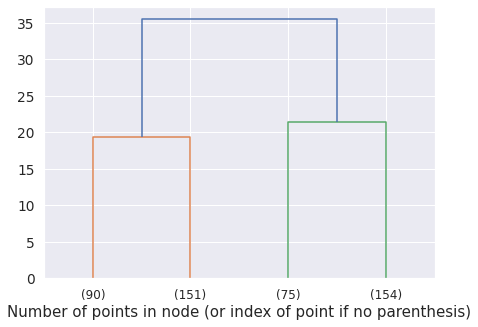

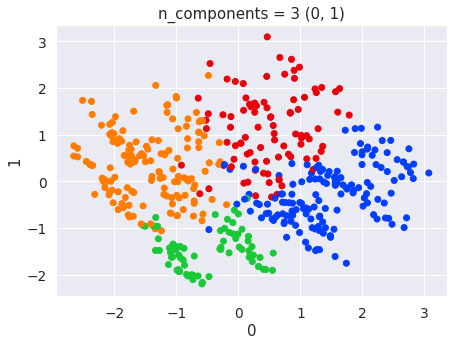

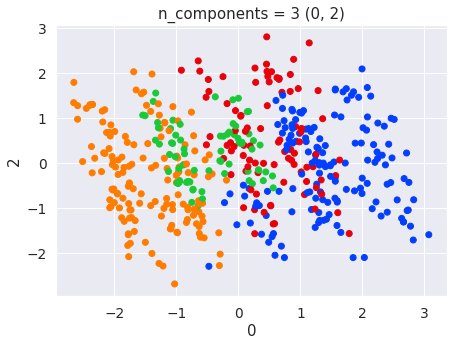

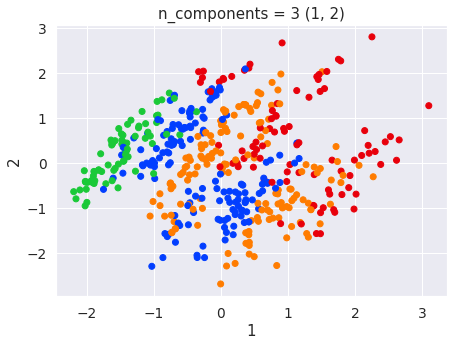

In [58]:
run_agglomerative_clustering(X_pca[:,:3], nClusters)

number of points in each cluster:  0: 205, 1: 84, 2: 131, 3: 50


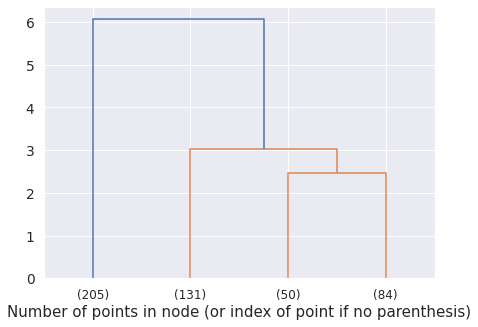

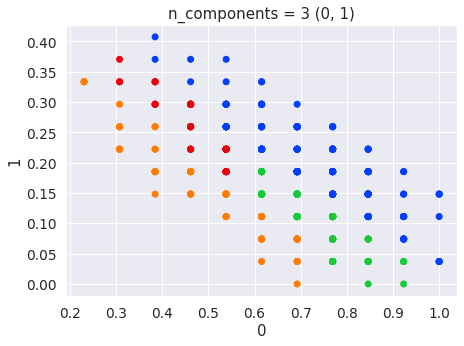

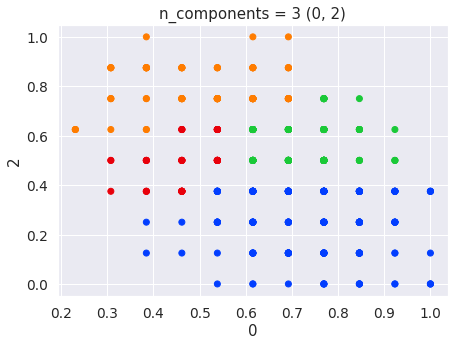

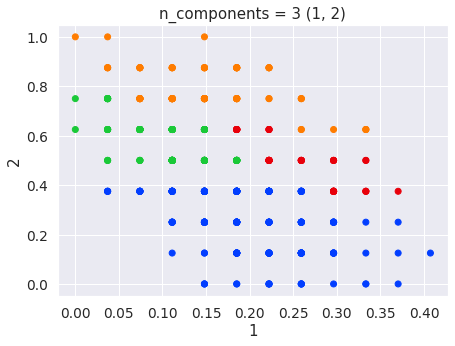

In [59]:
run_agglomerative_clustering(X_fa_allCat, nClusters)

Unfortunately we don't quite observe that, even for other choices of nClusters.